In [1]:
# implement the dqn for me using pytorch and openai gym
import matplotlib.pyplot as plt
from gym import spaces
import json
"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

# get the cuda
# import optimimzer
import torch.optim as optim
import torch.nn.functional as F
import random
import math
from collections import namedtuple
from itertools import count
from IPython import display
from torch.autograd import Variable
from collections import deque
import time


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = x.view(-1, input_dim)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x)) 
        x = torch.relu(self.linear3(x))
        return self.linear4(x)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
def int_to_tensor(x):
    return torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)

Using cuda


sampled action : 0
Sampled observation


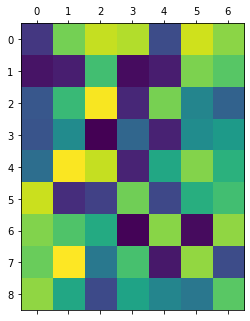

In [4]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4



def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { 
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = SCALE * np.power( np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [5]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) # define the transition tuple

class DQN_Agent(Agent):
    def __init__(self,  env:Env, epsilon:float = 0.7, batch_size: int = 2048, buffer_size: int = 20000, device = 'cuda', GAMMA : float = 0.9,
                 lr : float = 5e-3, policy_net = None, target_net = None, optimizer = None,
                # Additionnal parameters to be added here
                ):
        self.epsilon = epsilon
        self.env = env
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory_initial()
        self.device = device
        self.GAMMA = GAMMA
        self.lr = lr
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        torch.save(self.policy_net.state_dict(), savepath)
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.model.state_dict())
        pass

    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    # the action function for Q3a
    def act(self, obs, temp_epsilon):
        # write the epsilon-greedy policy here
        if random.random() < temp_epsilon:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            return self.policy_net(obs.to(self.device)).max(1)[1].view(1, 1) # return the action with the highest q-value
    
    # the action functio for Q3b
    def act_decay(self, obs, epsilon0, epsilonmin, Tmax, t):
        temp_epsilon = np.max([epsilon0*(Tmax-t)/Tmax, epsilonmin])
        return self.act(obs, temp_epsilon)
        
    def memory_initial(self):
        # initialize the memory
        self.memory = deque([],maxlen= self.buffer_size) # define the memory as a deque of size capacity

    def memory_push(self, transition):
        # push a transition into the memory
        self.memory.append(transition)

    def memory_sample(self):
        # sample a batch from memory
        return random.sample(self.memory, self.batch_size)
    
    def memory_len(self):
        # return the length of the memory
        return len(self.memory)
    
    def optimize_model(self, train = True):
        # This is where one would define the optimization step of an RL algorithm
        if self.memory_len() < self.batch_size:
            return 0
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions)) # unzip the batch

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device= self.device, dtype=torch.bool).to(device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch).to(device)
        next_state_values = torch.zeros(self.batch_size, device= self.device)


        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
                
        criterion = nn.MSELoss() # define the loss function

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) 
            self.optimizer.step()
        return loss.item()
    
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [7]:
def one_episode(env,agent,random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state, 0.7)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss
    
    return total_reward.item(), total_loss

def one_episode_decay(env,agent,random_seed, epsilon0, epsilonmin, Tmax, t):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act_decay(state, epsilon0, epsilonmin, Tmax, t)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss
    
    return total_reward.item(), total_loss


def eval_one(env,agent, random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state,0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss
    
    return total_reward.item(), total_loss


In [8]:

random_seed = 42 
BATCH_SIZE = 2048
GAMMA = 0.9
LR = 5e-3
input_dim = 3 * dyn.n_cities * dyn.env_step_length

state, info = env.reset(42)

# Initialize policy and target network
policy_net = DQN(input_dim, 2).to(device)
target_net = DQN(input_dim, 2).to(device)
# Initialize the target network to be the same as the policy network
target_net.load_state_dict(policy_net.state_dict()) 

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
DQNagent = DQN_Agent(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

num_episodes = 500

In [9]:
def train_Q3a():
    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode(env,DQNagent,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        #print(f"Episode {i} : reward {reward}, loss {loss}")
        if i % 5 == 0:
            DQNagent.update_target_model()
        if i % 50 == 0 :
            tuple_list = np.array([eval_one(env,DQNagent,i) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                torch.save(DQNagent.policy_net.state_dict(), "DQN_best_Q3a.pth")
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    with open('Q3a_train_loss.json', 'w') as f: json.dump(train_loss_trace, f)
    with open('Q3a_train_reward.json', 'w') as f: json.dump(train_reward_trace, f)
    with open('Q3a_eval_loss.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open('Q3a_eval_reward.json', 'w') as f: json.dump(eval_reward_trace, f)


In [10]:
train_Q3a()


Episode 50 : train_reward -192.67000050447425, train_loss 0.0
Episode 50 : eval_reward -176.40802001953125, eval_loss 0.0
Episode 100 : train_reward -148.6441714228416, train_loss 1000.9178486648871
Episode 100 : eval_reward 35.60824966430664, eval_loss 661.0403861999512
Episode 150 : train_reward -78.01274953569684, train_loss 333.07911659746753
Episode 150 : eval_reward 46.03912353515625, eval_loss 307.54472160339355
Episode 200 : train_reward -76.86134668272369, train_loss 306.1910204692763
Episode 200 : eval_reward 44.06410217285156, eval_loss 213.35752630233765
Episode 250 : train_reward -96.21481610804187, train_loss 295.2984266183814
Episode 250 : eval_reward 47.7631950378418, eval_loss 211.45114755630493
Episode 300 : train_reward -91.28488473259672, train_loss 280.17514145131014
Episode 300 : eval_reward 21.990591049194336, eval_loss 233.88743925094604
Episode 350 : train_reward -78.70853889231779, train_loss 295.7702656570746
Episode 350 : eval_reward 21.008136749267578, eval

In [13]:
DQNagentb = DQN_Agent(env, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net, target_net=target_net, optimizer=optimizer)

def train_Q3b():
    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode_decay(env,DQNagentb,i,0.7,0.2,500,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        #print(f"Episode {i} : reward {reward}, loss {loss}")
        if i % 5 == 0:
            DQNagent.update_target_model()
        if i % 50 == 0 :
            tuple_list = np.array([eval_one(env,DQNagent,i) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                torch.save(DQNagent.policy_net.state_dict(), "DQN_best_Q3b.pth")
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    with open('Q3b_train_loss.json', 'w') as f: json.dump(train_loss_trace, f)
    with open('Q3b_train_reward.json', 'w') as f: json.dump(train_reward_trace, f)
    with open('Q3b_eval_loss.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open('Q3b_eval_reward.json', 'w') as f: json.dump(eval_reward_trace, f)


In [12]:
def plot_pic(log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    from matplotlib.ticker import MultipleLocator
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

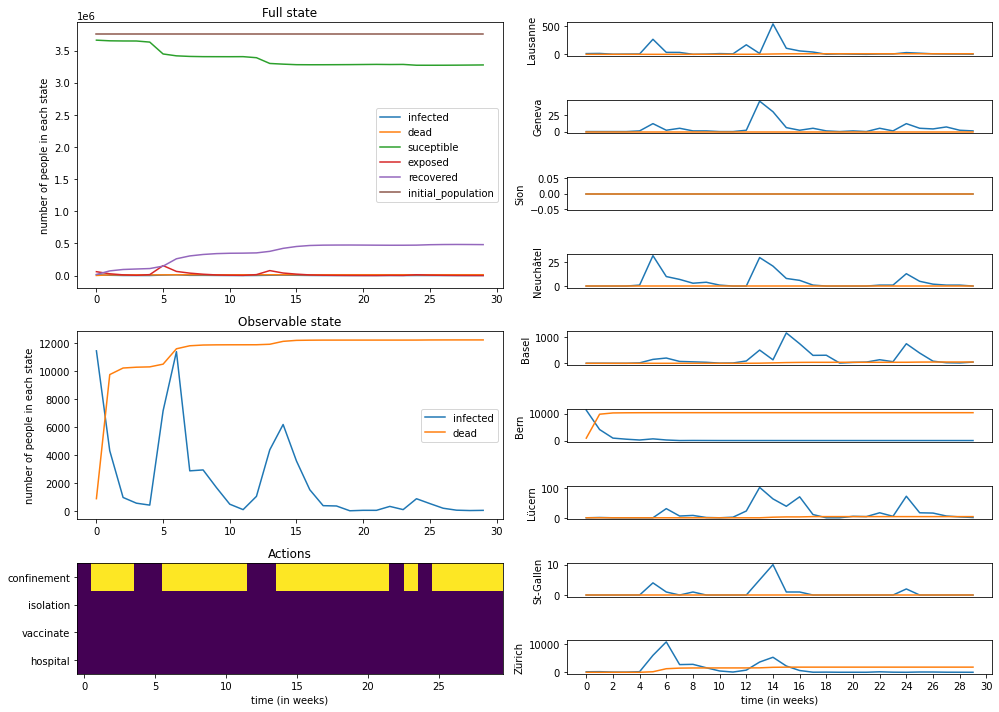

In [13]:



log2 = []
finished = False
obs, info = env.reset(42)

DQNagent.epsilon = 0
while not finished:
    action = DQNagent.act(obs,0)
    obs, R, finished, info = env.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break

plot_pic(log2)